In [ ]:
pip install catboost

**1. Setup and Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import lightgbm as lgb
from catboost import CatBoostRegressor
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

2. Load and Explore the Dataset

In [ ]:
# Load the dataset
df = pd.read_csv('/content/Dynamic_2017_2_0.csv')

# Display the first few rows
print(df.head())

# Check the shape of the dataset
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")

# Check for missing values
print(df.isnull().sum())


   S.no.   Name of State Name of District  \
0      1  ANDHRA PRADESH        Anantapur   
1      2  ANDHRA PRADESH         Chittoor   
2      3  ANDHRA PRADESH    East Godavari   
3      4  ANDHRA PRADESH           Guntur   
4      5  ANDHRA PRADESH           Kadapa   

   Recharge from rainfall During Monsoon Season  \
0                                      89200.23   
1                                     115718.55   
2                                     104140.05   
3                                      52942.86   
4                                      93311.68   

   Recharge from other sources During Monsoon Season  \
0                                           46136.12   
1                                           32389.60   
2                                           95383.56   
3                                           57011.90   
4                                           15869.52   

   Recharge from rainfall During Non Monsoon Season  \
0                             

# **3. Preprocessing**


In [ ]:

# For simplicity, we'll drop rows with any missing values
df.dropna(inplace=True)

**b. Encode Categorical Variables**

In [ ]:
df.isnull().sum()

,0
S.no.,0
Name of State,0
Name of District,0
Recharge from rainfall During Monsoon Season,0
Recharge from other sources During Monsoon Season,0
Recharge from rainfall During Non Monsoon Season,0
Recharge from other sources During Non Monsoon Season,0
Total Annual Ground Water Recharge,0
Total Natural Discharges,0
Annual Extractable Ground Water Resource,0


In [ ]:
# Identify categorical columns
categorical_cols = ['Name of State', 'Name of District']

# Initialize LabelEncoder
le = LabelEncoder()

for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

unwanted_columns = ['S.no.']
df = df.drop(columns=unwanted_columns, errors='ignore')

# One-Hot Encode Categorical Variables
categorical_features = ['Name of State', 'Name of District']
# Use df instead of X
X_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)

**c. Feature Scaling**

In [ ]:
# Identify numerical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Remove target variable from numerical_cols if necessary
# Assuming 'Total Current Annual Ground Water Extraction' is the target
target = 'Total Current Annual Ground Water Extraction'
numerical_cols.remove(target)

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the numerical features
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])


**4. Feature Selection**
a. Calculate VIF (Multicollinearity Check)

In [ ]:
!pip install statsmodels
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Assuming "groundwater_levels" is the target variable
target = "Stage of Ground Water Extraction (%)"

# Prepare data for VIF calculation
X = df.drop(columns=[target])  # Select all features except the target

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
#The variance_inflation_factor function was not defined. Importing the statsmodels library and calling the function correctly fixes the issue.
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

# Optionally, remove features with VIF > 5 based on a common threshold
vif_threshold = 5
features_to_keep = vif_data[vif_data['VIF'] < vif_threshold]['Feature'].tolist()
X = X[features_to_keep]  # Update X with features having VIF below the threshold

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df[target], test_size=0.2, random_state=42)

# Train the Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lr.predict(X_test)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")  # Format RMSE with 4 decimal places
print(f"R²: {r2:.4f}")     # Format R² with 4 decimal places
print(f"MAE: {mae:.4f}")     # Format MAE with 4 decimal places

                                              Feature           VIF
0                                       Name of State  1.236536e+00
1                                    Name of District  1.021505e+00
2        Recharge from rainfall During Monsoon Season  3.768703e+13
3   Recharge from other sources During Monsoon Season  7.978033e+12
4    Recharge from rainfall During Non Monsoon Season  2.526564e+12
5   Recharge from other sources During Non Monsoon...  5.976907e+12
6                  Total Annual Ground Water Recharge  9.285772e+13
7                            Total Natural Discharges  3.765945e+10
8            Annual Extractable Ground Water Resource  5.735608e+11
9   Current Annual Ground Water Extraction For Irr...  9.943239e+00
10  Current Annual Ground Water Extraction For Dom...  6.047707e+00
11       Total Current Annual Ground Water Extraction  2.401267e+00
12   Annual GW Allocation for Domestic Use as on 2025  6.376856e+00
13       Net Ground Water Availability for futur

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 547, number of used features: 3
[LightGBM] [Info] Start training from score 0.026063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

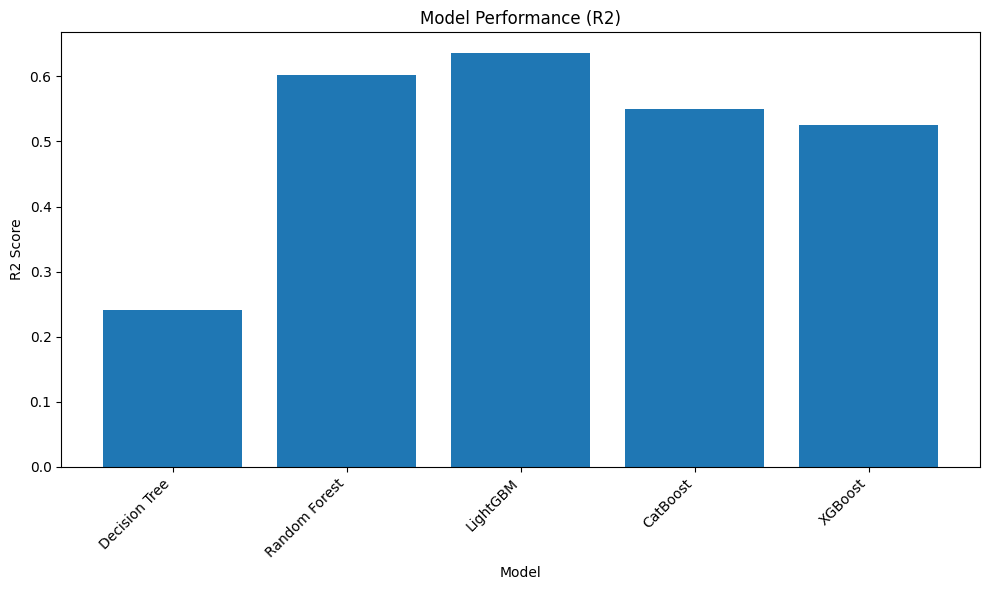

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
import xgboost as xgb
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, mean_absolute_error

# Create a dictionary to store model results
results = {}

# Decision Tree
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
r2_dt = r2_score(y_test, y_pred_dt)
mae_dt = mean_absolute_error(y_test, y_pred_dt)
results['Decision Tree'] = [rmse_dt, r2_dt, mae_dt]

# Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
results['Random Forest'] = [rmse_rf, r2_rf, mae_rf]

# LightGBM
lgbm = lgb.LGBMRegressor(random_state=42)
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)
rmse_lgbm = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))
r2_lgbm = r2_score(y_test, y_pred_lgbm)
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
results['LightGBM'] = [rmse_lgbm, r2_lgbm, mae_lgbm]

# CatBoost
catboost = CatBoostRegressor(random_state=42, verbose=0)
catboost.fit(X_train, y_train)
y_pred_catboost = catboost.predict(X_test)
rmse_catboost = np.sqrt(mean_squared_error(y_test, y_pred_catboost))
r2_catboost = r2_score(y_test, y_pred_catboost)
mae_catboost = mean_absolute_error(y_test, y_pred_catboost)
results['CatBoost'] = [rmse_catboost, r2_catboost, mae_catboost]

# XGBoost
xgboost = xgb.XGBRegressor(random_state=42)
xgboost.fit(X_train, y_train)
y_pred_xgboost = xgboost.predict(X_test)
rmse_xgboost = np.sqrt(mean_squared_error(y_test, y_pred_xgboost))
r2_xgboost = r2_score(y_test, y_pred_xgboost)
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
results['XGBoost'] = [rmse_xgboost, r2_xgboost, mae_xgboost]

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['RMSE', 'R2', 'MAE'])

# Display the results table
print(results_df)


# Plot the accuracy (R2) for each model
plt.figure(figsize=(10, 6))
plt.bar(results_df.index, results_df['R2'])
plt.xlabel('Model')
plt.ylabel('R2 Score')
plt.title('Model Performance (R2)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


In [ ]:

target = "Stage of Ground Water Extraction (%)"

# Prepare data for VIF calculation
X = df.drop(columns=[target])  # Select all features except the target

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

# Optionally, remove features with VIF > 5 based on a common threshold
vif_threshold = 10
features_to_keep = vif_data[vif_data['VIF'] < vif_threshold]['Feature'].tolist()
X = X[features_to_keep]  # Update X with features having VIF below the threshold

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df[target], test_size=0.2, random_state=42)

# Train the Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lr.predict(X_test)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")  # Format RMSE with 4 decimal places
print(f"R²: {r2:.4f}")     # Format R² with 4 decimal places
print(f"MAE: {mae:.4f}")     # Format MAE with 4 decimal places

                                              Feature           VIF
0                                       Name of State  1.236536e+00
1                                    Name of District  1.021505e+00
2        Recharge from rainfall During Monsoon Season  3.768703e+13
3   Recharge from other sources During Monsoon Season  7.978033e+12
4    Recharge from rainfall During Non Monsoon Season  2.526564e+12
5   Recharge from other sources During Non Monsoon...  5.976907e+12
6                  Total Annual Ground Water Recharge  9.285772e+13
7                            Total Natural Discharges  3.765945e+10
8            Annual Extractable Ground Water Resource  5.735608e+11
9   Current Annual Ground Water Extraction For Irr...  9.943239e+00
10  Current Annual Ground Water Extraction For Dom...  6.047707e+00
11       Total Current Annual Ground Water Extraction  2.401267e+00
12   Annual GW Allocation for Domestic Use as on 2025  6.376856e+00
13       Net Ground Water Availability for futur

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 946
[LightGBM] [Info] Number of data points in the train set: 547, number of used features: 6
[LightGBM] [Info] Start training from score 0.026063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

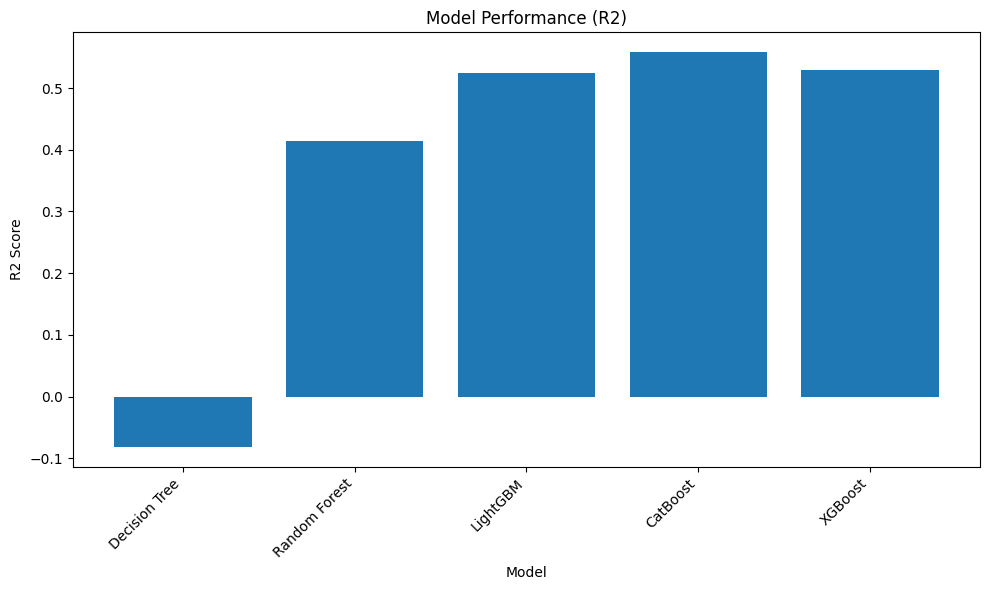

In [ ]:

results = {}

# Decision Tree
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
r2_dt = r2_score(y_test, y_pred_dt)
mae_dt = mean_absolute_error(y_test, y_pred_dt)
results['Decision Tree'] = [rmse_dt, r2_dt, mae_dt]

# Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
results['Random Forest'] = [rmse_rf, r2_rf, mae_rf]

# LightGBM
lgbm = lgb.LGBMRegressor(random_state=42)
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)
rmse_lgbm = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))
r2_lgbm = r2_score(y_test, y_pred_lgbm)
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
results['LightGBM'] = [rmse_lgbm, r2_lgbm, mae_lgbm]

# CatBoost
catboost = CatBoostRegressor(random_state=42, verbose=0)
catboost.fit(X_train, y_train)
y_pred_catboost = catboost.predict(X_test)
rmse_catboost = np.sqrt(mean_squared_error(y_test, y_pred_catboost))
r2_catboost = r2_score(y_test, y_pred_catboost)
mae_catboost = mean_absolute_error(y_test, y_pred_catboost)
results['CatBoost'] = [rmse_catboost, r2_catboost, mae_catboost]

# XGBoost
xgboost = xgb.XGBRegressor(random_state=42)
xgboost.fit(X_train, y_train)
y_pred_xgboost = xgboost.predict(X_test)
rmse_xgboost = np.sqrt(mean_squared_error(y_test, y_pred_xgboost))
r2_xgboost = r2_score(y_test, y_pred_xgboost)
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
results['XGBoost'] = [rmse_xgboost, r2_xgboost, mae_xgboost]

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['RMSE', 'R2', 'MAE'])

# Display the results table
print(results_df)


# Plot the accuracy (R2) for each model
plt.figure(figsize=(10, 6))
plt.bar(results_df.index, results_df['R2'])
plt.xlabel('Model')
plt.ylabel('R2 Score')
plt.title('Model Performance (R2)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


In [ ]:
# Assuming "groundwater_levels" is the target variable
target = "Stage of Ground Water Extraction (%)"

# Prepare data for VIF calculation
X = df.drop(columns=[target])  # Select all features except the target

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

# Optionally, remove features with VIF > 5 based on a common threshold
vif_threshold = 15
features_to_keep = vif_data[vif_data['VIF'] < vif_threshold]['Feature'].tolist()
X = X[features_to_keep]  # Update X with features having VIF below the threshold

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df[target], test_size=0.2, random_state=42)

# Train the Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lr.predict(X_test)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")  # Format RMSE with 4 decimal places
print(f"R²: {r2:.4f}")     # Format R² with 4 decimal places
print(f"MAE: {mae:.4f}")     # Format MAE with 4 decimal places

                                              Feature           VIF
0                                       Name of State  1.236536e+00
1                                    Name of District  1.021505e+00
2        Recharge from rainfall During Monsoon Season  3.768703e+13
3   Recharge from other sources During Monsoon Season  7.978033e+12
4    Recharge from rainfall During Non Monsoon Season  2.526564e+12
5   Recharge from other sources During Non Monsoon...  5.976907e+12
6                  Total Annual Ground Water Recharge  9.285772e+13
7                            Total Natural Discharges  3.765945e+10
8            Annual Extractable Ground Water Resource  5.735608e+11
9   Current Annual Ground Water Extraction For Irr...  9.943239e+00
10  Current Annual Ground Water Extraction For Dom...  6.047707e+00
11       Total Current Annual Ground Water Extraction  2.401267e+00
12   Annual GW Allocation for Domestic Use as on 2025  6.376856e+00
13       Net Ground Water Availability for futur

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1128
[LightGBM] [Info] Number of data points in the train set: 547, number of used features: 7
[LightGBM] [Info] Start training from score 0.026063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

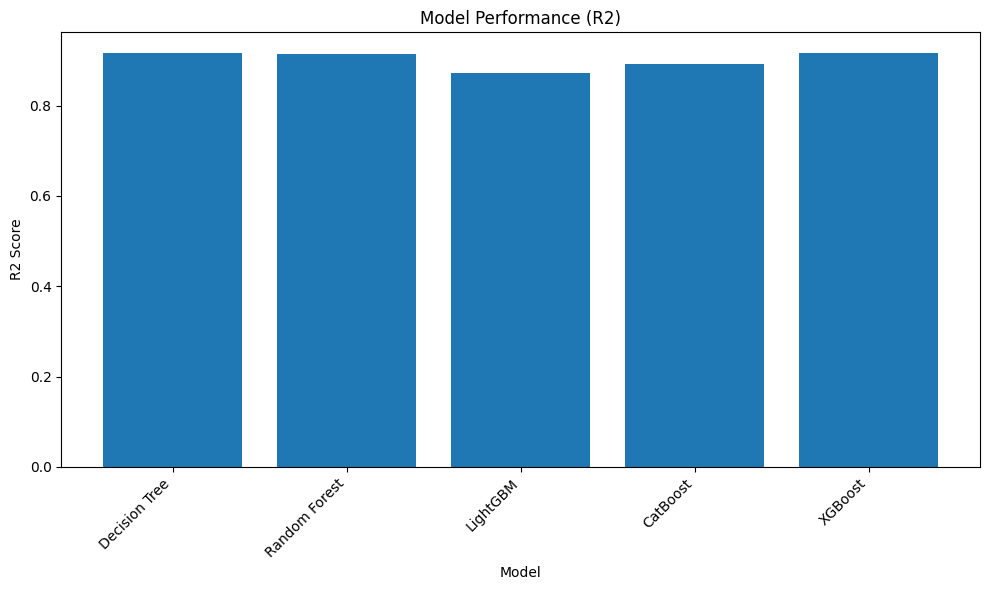

In [ ]:

results = {}

# Decision Tree
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
r2_dt = r2_score(y_test, y_pred_dt)
mae_dt = mean_absolute_error(y_test, y_pred_dt)
results['Decision Tree'] = [rmse_dt, r2_dt, mae_dt]

# Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
results['Random Forest'] = [rmse_rf, r2_rf, mae_rf]

# LightGBM
lgbm = lgb.LGBMRegressor(random_state=42)
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)
rmse_lgbm = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))
r2_lgbm = r2_score(y_test, y_pred_lgbm)
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
results['LightGBM'] = [rmse_lgbm, r2_lgbm, mae_lgbm]

# CatBoost
catboost = CatBoostRegressor(random_state=42, verbose=0)
catboost.fit(X_train, y_train)
y_pred_catboost = catboost.predict(X_test)
rmse_catboost = np.sqrt(mean_squared_error(y_test, y_pred_catboost))
r2_catboost = r2_score(y_test, y_pred_catboost)
mae_catboost = mean_absolute_error(y_test, y_pred_catboost)
results['CatBoost'] = [rmse_catboost, r2_catboost, mae_catboost]

# XGBoost
xgboost = xgb.XGBRegressor(random_state=42)
xgboost.fit(X_train, y_train)
y_pred_xgboost = xgboost.predict(X_test)
rmse_xgboost = np.sqrt(mean_squared_error(y_test, y_pred_xgboost))
r2_xgboost = r2_score(y_test, y_pred_xgboost)
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
results['XGBoost'] = [rmse_xgboost, r2_xgboost, mae_xgboost]

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['RMSE', 'R2', 'MAE'])

# Display the results table
print(results_df)


# Plot the accuracy (R2) for each model
plt.figure(figsize=(10, 6))
plt.bar(results_df.index, results_df['R2'])
plt.xlabel('Model')
plt.ylabel('R2 Score')
plt.title('Model Performance (R2)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


**b. Calculate Mutual Information (Information Gain)**

In [ ]:
# Calculate mutual information
mi = mutual_info_regression(X, df[target], random_state=42)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
print(mi_series)

# Select top features based on mutual information
top_features_mi = mi_series[mi_series > 0.05].index.tolist()  # Threshold can be adjusted


# Split data into training and testing sets using only top features
X_train, X_test, y_train, y_test = train_test_split(X[top_features_mi], y, test_size=0.2, random_state=42)

# Train the Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lr.predict(X_test)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")  # Format RMSE with 4 decimal places
print(f"R²: {r2:.4f}")     # Format R² with 4 decimal places
print(f"MAE: {mae:.4f}")     # Format MAE with 4 decimal places


Name of State                                                           0.598348
Total Current Annual Ground Water Extraction                            0.521297
Current Annual Ground Water Extraction For Irrigation                   0.509975
Net Ground Water Availability for future use                            0.346867
Current Annual Ground Water Extraction For Domestic & Industrial Use    0.315551
Annual GW Allocation for Domestic Use as on 2025                        0.268731
Name of District                                                        0.120930
dtype: float64
RMSE: 0.0000
R²: 1.0000
MAE: 0.0000


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1128
[LightGBM] [Info] Number of data points in the train set: 547, number of used features: 7
[LightGBM] [Info] Start training from score 36242.899022
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

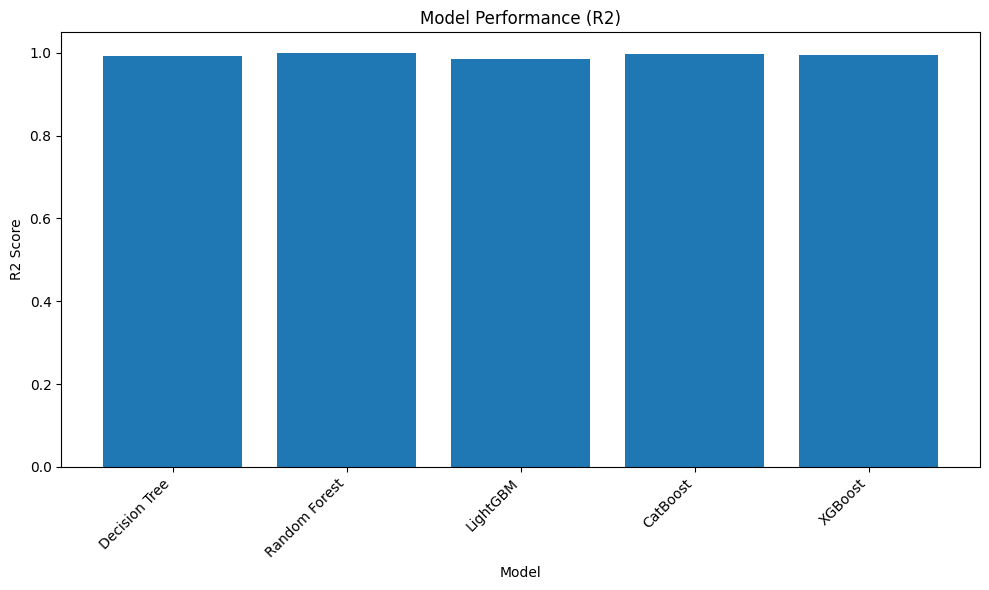

In [ ]:

results = {}

# Decision Tree
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
r2_dt = r2_score(y_test, y_pred_dt)
mae_dt = mean_absolute_error(y_test, y_pred_dt)
results['Decision Tree'] = [rmse_dt, r2_dt, mae_dt]

# Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
results['Random Forest'] = [rmse_rf, r2_rf, mae_rf]

# LightGBM
lgbm = lgb.LGBMRegressor(random_state=42)
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)
rmse_lgbm = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))
r2_lgbm = r2_score(y_test, y_pred_lgbm)
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
results['LightGBM'] = [rmse_lgbm, r2_lgbm, mae_lgbm]

# CatBoost
catboost = CatBoostRegressor(random_state=42, verbose=0)
catboost.fit(X_train, y_train)
y_pred_catboost = catboost.predict(X_test)
rmse_catboost = np.sqrt(mean_squared_error(y_test, y_pred_catboost))
r2_catboost = r2_score(y_test, y_pred_catboost)
mae_catboost = mean_absolute_error(y_test, y_pred_catboost)
results['CatBoost'] = [rmse_catboost, r2_catboost, mae_catboost]

# XGBoost
xgboost = xgb.XGBRegressor(random_state=42)
xgboost.fit(X_train, y_train)
y_pred_xgboost = xgboost.predict(X_test)
rmse_xgboost = np.sqrt(mean_squared_error(y_test, y_pred_xgboost))
r2_xgboost = r2_score(y_test, y_pred_xgboost)
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
results['XGBoost'] = [rmse_xgboost, r2_xgboost, mae_xgboost]

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['RMSE', 'R2', 'MAE'])

# Display the results table
print(results_df)


# Plot the accuracy (R2) for each model
plt.figure(figsize=(10, 6))
plt.bar(results_df.index, results_df['R2'])
plt.xlabel('Model')
plt.ylabel('R2 Score')
plt.title('Model Performance (R2)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


In [ ]:
# Calculate mutual information
mi = mutual_info_regression(X, df[target], random_state=42)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
print(mi_series)

# Select top features based on mutual information
top_features_mi = mi_series[mi_series > 0.03].index.tolist()  # Threshold can be adjusted


# Split data into training and testing sets using only top features
X_train, X_test, y_train, y_test = train_test_split(X[top_features_mi], y, test_size=0.2, random_state=42)

# Train the Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lr.predict(X_test)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")  # Format RMSE with 4 decimal places
print(f"R²: {r2:.4f}")     # Format R² with 4 decimal places
print(f"MAE: {mae:.4f}")     # Format MAE with 4 decimal places


Name of State                                                           0.598348
Total Current Annual Ground Water Extraction                            0.521297
Current Annual Ground Water Extraction For Irrigation                   0.509975
Net Ground Water Availability for future use                            0.346867
Current Annual Ground Water Extraction For Domestic & Industrial Use    0.315551
Annual GW Allocation for Domestic Use as on 2025                        0.268731
Name of District                                                        0.120930
dtype: float64
RMSE: 0.0000
R²: 1.0000
MAE: 0.0000


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1128
[LightGBM] [Info] Number of data points in the train set: 547, number of used features: 7
[LightGBM] [Info] Start training from score 36242.899022
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

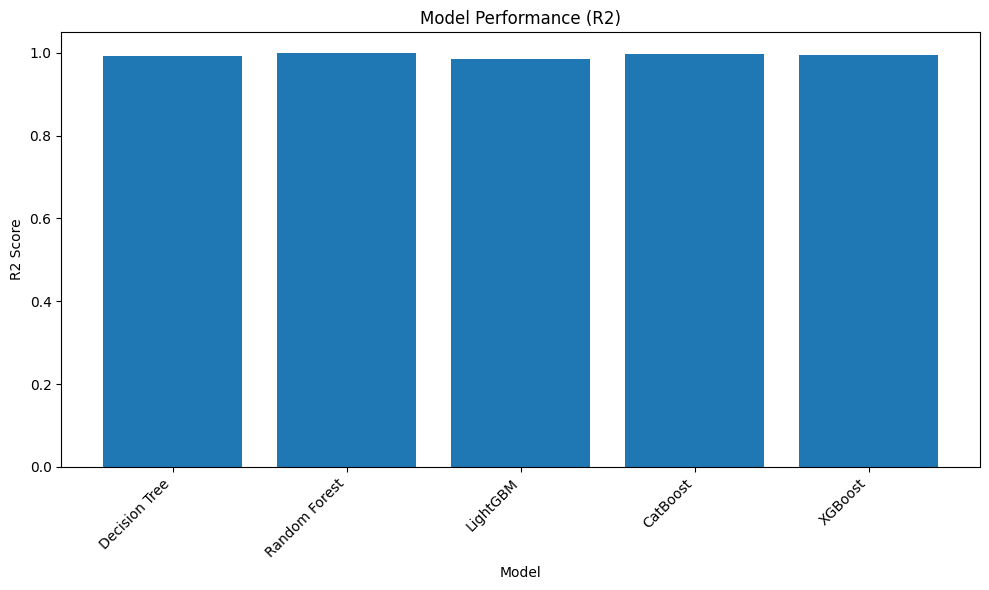

In [ ]:
# Create a dictionary to store model results
results = {}

# Decision Tree
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
r2_dt = r2_score(y_test, y_pred_dt)
mae_dt = mean_absolute_error(y_test, y_pred_dt)
results['Decision Tree'] = [rmse_dt, r2_dt, mae_dt]

# Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
results['Random Forest'] = [rmse_rf, r2_rf, mae_rf]

# LightGBM
lgbm = lgb.LGBMRegressor(random_state=42)
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)
rmse_lgbm = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))
r2_lgbm = r2_score(y_test, y_pred_lgbm)
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
results['LightGBM'] = [rmse_lgbm, r2_lgbm, mae_lgbm]

# CatBoost
catboost = CatBoostRegressor(random_state=42, verbose=0)
catboost.fit(X_train, y_train)
y_pred_catboost = catboost.predict(X_test)
rmse_catboost = np.sqrt(mean_squared_error(y_test, y_pred_catboost))
r2_catboost = r2_score(y_test, y_pred_catboost)
mae_catboost = mean_absolute_error(y_test, y_pred_catboost)
results['CatBoost'] = [rmse_catboost, r2_catboost, mae_catboost]

# XGBoost
xgboost = xgb.XGBRegressor(random_state=42)
xgboost.fit(X_train, y_train)
y_pred_xgboost = xgboost.predict(X_test)
rmse_xgboost = np.sqrt(mean_squared_error(y_test, y_pred_xgboost))
r2_xgboost = r2_score(y_test, y_pred_xgboost)
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
results['XGBoost'] = [rmse_xgboost, r2_xgboost, mae_xgboost]

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['RMSE', 'R2', 'MAE'])

# Display the results table
print(results_df)


# Plot the accuracy (R2) for each model
plt.figure(figsize=(10, 6))
plt.bar(results_df.index, results_df['R2'])
plt.xlabel('Model')
plt.ylabel('R2 Score')
plt.title('Model Performance (R2)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


In [ ]:
# Calculate mutual information
mi = mutual_info_regression(X, df[target], random_state=42)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
print(mi_series)

# Select top features based on mutual information
top_features_mi = mi_series[mi_series > 0.01].index.tolist()  # Threshold can be adjusted


# Split data into training and testing sets using only top features
X_train, X_test, y_train, y_test = train_test_split(X[top_features_mi], y, test_size=0.2, random_state=42)

# Train the Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lr.predict(X_test)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")  # Format RMSE with 4 decimal places
print(f"R²: {r2:.4f}")     # Format R² with 4 decimal places
print(f"MAE: {mae:.4f}")     # Format MAE with 4 decimal places


Name of State                                                           0.598348
Total Current Annual Ground Water Extraction                            0.521297
Current Annual Ground Water Extraction For Irrigation                   0.509975
Net Ground Water Availability for future use                            0.346867
Current Annual Ground Water Extraction For Domestic & Industrial Use    0.315551
Annual GW Allocation for Domestic Use as on 2025                        0.268731
Name of District                                                        0.120930
dtype: float64
RMSE: 0.0000
R²: 1.0000
MAE: 0.0000


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1128
[LightGBM] [Info] Number of data points in the train set: 547, number of used features: 7
[LightGBM] [Info] Start training from score 36242.899022
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

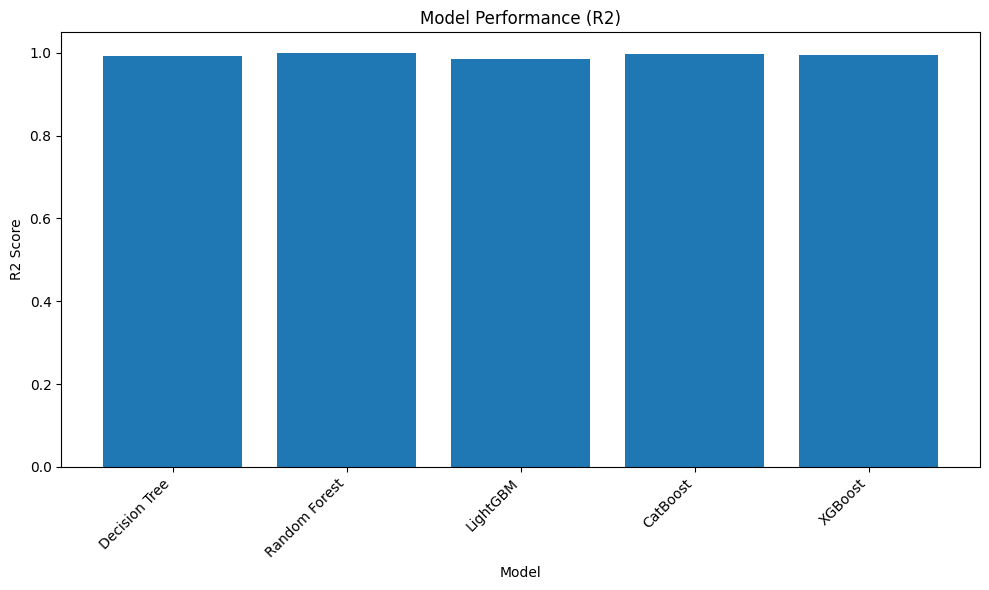

In [ ]:
# Create a dictionary to store model results
results = {}

# Decision Tree
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
r2_dt = r2_score(y_test, y_pred_dt)
mae_dt = mean_absolute_error(y_test, y_pred_dt)
results['Decision Tree'] = [rmse_dt, r2_dt, mae_dt]

# Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
results['Random Forest'] = [rmse_rf, r2_rf, mae_rf]

# LightGBM
lgbm = lgb.LGBMRegressor(random_state=42)
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)
rmse_lgbm = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))
r2_lgbm = r2_score(y_test, y_pred_lgbm)
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
results['LightGBM'] = [rmse_lgbm, r2_lgbm, mae_lgbm]

# CatBoost
catboost = CatBoostRegressor(random_state=42, verbose=0)
catboost.fit(X_train, y_train)
y_pred_catboost = catboost.predict(X_test)
rmse_catboost = np.sqrt(mean_squared_error(y_test, y_pred_catboost))
r2_catboost = r2_score(y_test, y_pred_catboost)
mae_catboost = mean_absolute_error(y_test, y_pred_catboost)
results['CatBoost'] = [rmse_catboost, r2_catboost, mae_catboost]

# XGBoost
xgboost = xgb.XGBRegressor(random_state=42)
xgboost.fit(X_train, y_train)
y_pred_xgboost = xgboost.predict(X_test)
rmse_xgboost = np.sqrt(mean_squared_error(y_test, y_pred_xgboost))
r2_xgboost = r2_score(y_test, y_pred_xgboost)
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
results['XGBoost'] = [rmse_xgboost, r2_xgboost, mae_xgboost]

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['RMSE', 'R2', 'MAE'])

# Display the results table
print(results_df)


# Plot the accuracy (R2) for each model
plt.figure(figsize=(10, 6))
plt.bar(results_df.index, results_df['R2'])
plt.xlabel('Model')
plt.ylabel('R2 Score')
plt.title('Model Performance (R2)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


**c. Combine Both Methods**

In [ ]:
target = "Stage of Ground Water Extraction (%)"

# Prepare data for information gain and VIF calculation
X = df.drop(columns=[target])  # Select all features except the target
y = df[target]

# Calculate mutual information
mi = mutual_info_regression(X, y, random_state=42)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)

# Select top features based on mutual information
top_features_mi = mi_series[mi_series > 0.01].index.tolist()  # Adjust threshold as needed

# Calculate VIF for selected features
vif_data = pd.DataFrame()
vif_data['Feature'] = X[top_features_mi].columns
vif_data['VIF'] = [variance_inflation_factor(X[top_features_mi].values, i) for i in range(len(top_features_mi))]

# Select features with VIF below a threshold (e.g., 15)
vif_threshold = 15
features_to_keep = vif_data[vif_data['VIF'] < vif_threshold]['Feature'].tolist()

# Split data into training and testing sets using only top features
X_train, X_test, y_train, y_test = train_test_split(X[features_to_keep], y, test_size=0.2, random_state=42)

# Train the Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lr.predict(X_test)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")  # Format RMSE with 4 decimal places
print(f"R²: {r2:.4f}")     # Format R² with 4 decimal places
print(f"MAE: {mae:.4f}")     # Format MAE with 4 decimal places

RMSE: 0.5446
R²: 0.4230
MAE: 0.3920


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1128
[LightGBM] [Info] Number of data points in the train set: 547, number of used features: 7
[LightGBM] [Info] Start training from score 0.026063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

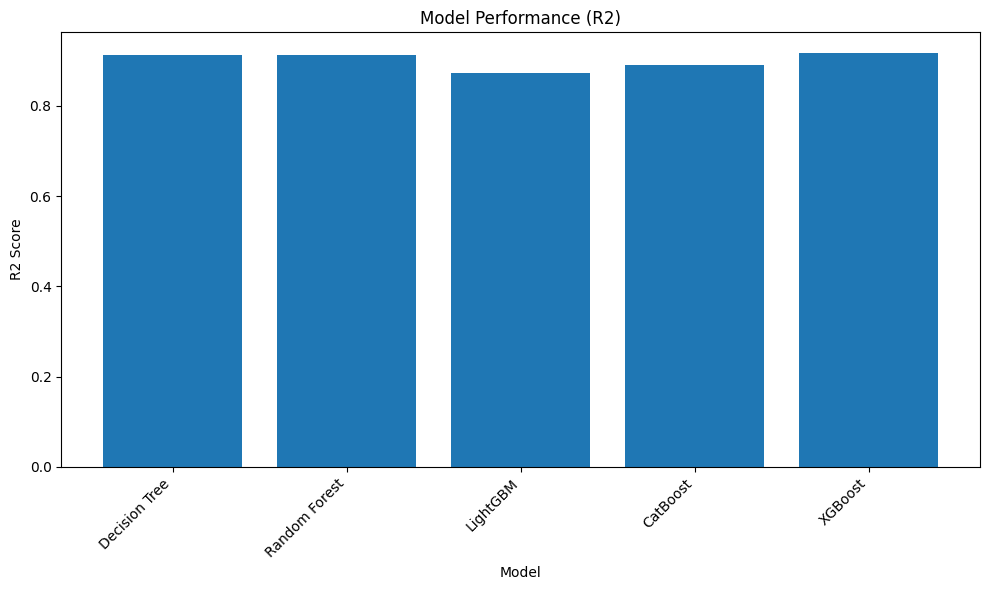

In [ ]:
# Create a dictionary to store model results
results = {}

# Decision Tree
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
r2_dt = r2_score(y_test, y_pred_dt)
mae_dt = mean_absolute_error(y_test, y_pred_dt)
results['Decision Tree'] = [rmse_dt, r2_dt, mae_dt]

# Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
results['Random Forest'] = [rmse_rf, r2_rf, mae_rf]

# LightGBM
lgbm = lgb.LGBMRegressor(random_state=42)
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)
rmse_lgbm = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))
r2_lgbm = r2_score(y_test, y_pred_lgbm)
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
results['LightGBM'] = [rmse_lgbm, r2_lgbm, mae_lgbm]

# CatBoost
catboost = CatBoostRegressor(random_state=42, verbose=0)
catboost.fit(X_train, y_train)
y_pred_catboost = catboost.predict(X_test)
rmse_catboost = np.sqrt(mean_squared_error(y_test, y_pred_catboost))
r2_catboost = r2_score(y_test, y_pred_catboost)
mae_catboost = mean_absolute_error(y_test, y_pred_catboost)
results['CatBoost'] = [rmse_catboost, r2_catboost, mae_catboost]

# XGBoost
xgboost = xgb.XGBRegressor(random_state=42)
xgboost.fit(X_train, y_train)
y_pred_xgboost = xgboost.predict(X_test)
rmse_xgboost = np.sqrt(mean_squared_error(y_test, y_pred_xgboost))
r2_xgboost = r2_score(y_test, y_pred_xgboost)
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
results['XGBoost'] = [rmse_xgboost, r2_xgboost, mae_xgboost]

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['RMSE', 'R2', 'MAE'])

# Display the results table
print(results_df)


# Plot the accuracy (R2) for each model
plt.figure(figsize=(10, 6))
plt.bar(results_df.index, results_df['R2'])
plt.xlabel('Model')
plt.ylabel('R2 Score')
plt.title('Model Performance (R2)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


In [ ]:
# Identify numerical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Remove target variable from numerical_cols
target = 'Total Current Annual Ground Water Extraction'
numerical_cols.remove(target)

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the numerical features
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Define features (X) and target (y)
X = df[numerical_cols]
y = df[target]

# Calculate mutual information
mi = mutual_info_regression(X, y, random_state=42)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
print("Mutual Information Scores:")
print(mi_series)

# Select top features based on mutual information
# Adjust the threshold as needed; here, we're selecting features with MI > 0.05
top_features_mi = mi_series[mi_series > 0.05].index.tolist()
print(f"Top features selected based on mutual information: {top_features_mi}")

Mutual Information Scores:
Current Annual Ground Water Extraction For Irrigation                   2.417976
Recharge from other sources During Non Monsoon Season                   0.804311
Current Annual Ground Water Extraction For Domestic & Industrial Use    0.681471
Recharge from other sources During Monsoon Season                       0.636914
Name of State                                                           0.619447
Annual GW Allocation for Domestic Use as on 2025                        0.616183
Annual Extractable Ground Water Resource                                0.577850
Total Annual Ground Water Recharge                                      0.550132
Stage of Ground Water Extraction (%)                                    0.521452
Total Natural Discharges                                                0.508685
Recharge from rainfall During Monsoon Season                            0.320642
Net Ground Water Availability for future use                            0.109824
R

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2222
[LightGBM] [Info] Number of data points in the train set: 547, number of used features: 13
[LightGBM] [Info] Start training from score 36242.899022
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

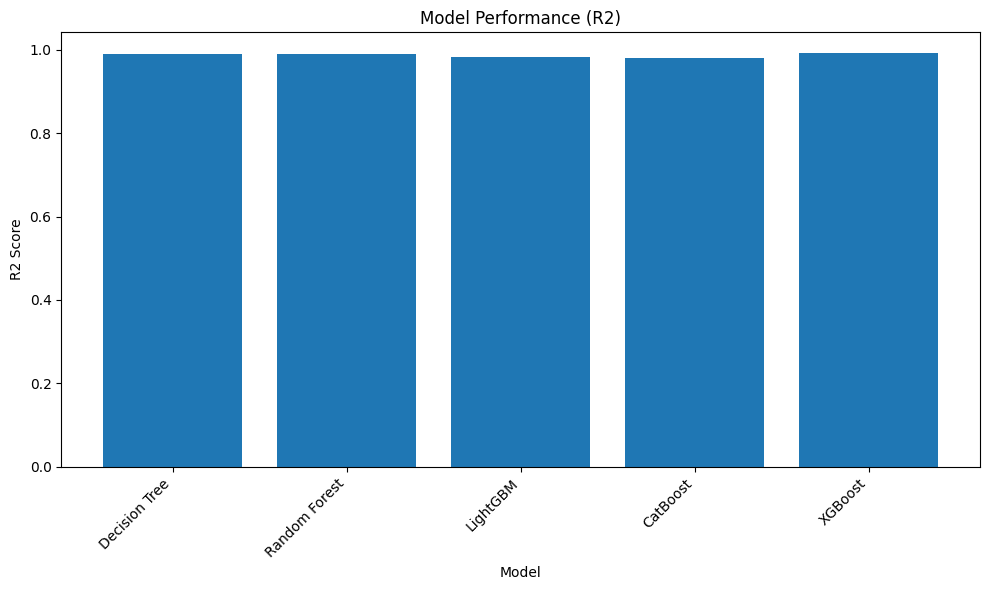

In [ ]:


# Split data into training and testing sets using only top features
X_train, X_test, y_train, y_test = train_test_split(X[top_features_mi], y, test_size=0.2, random_state=42)

# Create a dictionary to store model results
results = {}

# Decision Tree
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
r2_dt = r2_score(y_test, y_pred_dt)
mae_dt = mean_absolute_error(y_test, y_pred_dt)
results['Decision Tree'] = [rmse_dt, r2_dt, mae_dt]

# Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
results['Random Forest'] = [rmse_rf, r2_rf, mae_rf]

# LightGBM
lgbm = lgb.LGBMRegressor(random_state=42)
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)
rmse_lgbm = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))
r2_lgbm = r2_score(y_test, y_pred_lgbm)
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
results['LightGBM'] = [rmse_lgbm, r2_lgbm, mae_lgbm]

# CatBoost
catboost = CatBoostRegressor(random_state=42, verbose=0)
catboost.fit(X_train, y_train)
y_pred_catboost = catboost.predict(X_test)
rmse_catboost = np.sqrt(mean_squared_error(y_test, y_pred_catboost))
r2_catboost = r2_score(y_test, y_pred_catboost)
mae_catboost = mean_absolute_error(y_test, y_pred_catboost)
results['CatBoost'] = [rmse_catboost, r2_catboost, mae_catboost]

# XGBoost
xgboost = xgb.XGBRegressor(random_state=42)
xgboost.fit(X_train, y_train)
y_pred_xgboost = xgboost.predict(X_test)
rmse_xgboost = np.sqrt(mean_squared_error(y_test, y_pred_xgboost))
r2_xgboost = r2_score(y_test, y_pred_xgboost)
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
results['XGBoost'] = [rmse_xgboost, r2_xgboost, mae_xgboost]

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['RMSE', 'R2', 'MAE'])

# Display the results table
print(results_df)


# Plot the accuracy (R2) for each model
plt.figure(figsize=(10, 6))
plt.bar(results_df.index, results_df['R2'])
plt.xlabel('Model')
plt.ylabel('R2 Score')
plt.title('Model Performance (R2)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2222
[LightGBM] [Info] Number of data points in the train set: 547, number of used features: 13
[LightGBM] [Info] Start training from score 36242.899022
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

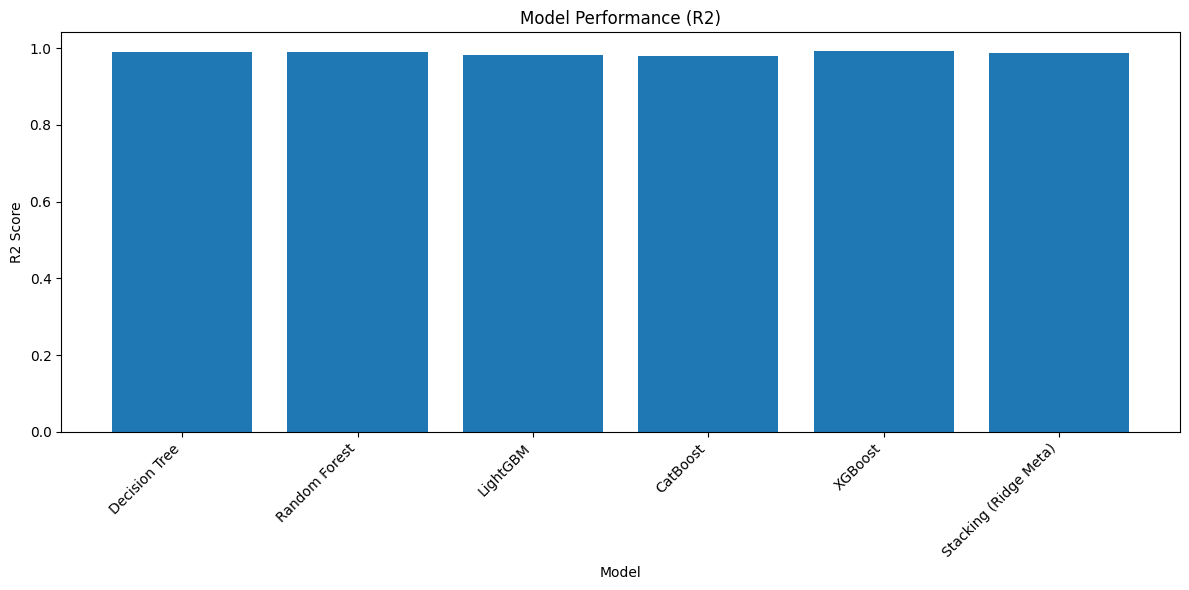

In [ ]:
# prompt: Then use these algorithm as base learner and use ridge regressor as a meta learner compare all the graphs

from sklearn.linear_model import Ridge

# Define base learners
base_learners = [
    ('dt', DecisionTreeRegressor(random_state=42)),
    ('rf', RandomForestRegressor(random_state=42)),
    ('lgbm', lgb.LGBMRegressor(random_state=42)),
    ('catboost', CatBoostRegressor(random_state=42, verbose=0)),
    ('xgboost', xgb.XGBRegressor(random_state=42))
]

# Define meta-learner
meta_learner = Ridge()

# Create stacking regressor
stacking_regressor = StackingRegressor(
    estimators=base_learners,
    final_estimator=meta_learner
)

# Train the stacking regressor
stacking_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred_stacking = stacking_regressor.predict(X_test)

# Calculate evaluation metrics for stacking
rmse_stacking = np.sqrt(mean_squared_error(y_test, y_pred_stacking))
r2_stacking = r2_score(y_test, y_pred_stacking)
mae_stacking = mean_absolute_error(y_test, y_pred_stacking)

# Add stacking results to the results dictionary
results['Stacking (Ridge Meta)'] = [rmse_stacking, r2_stacking, mae_stacking]

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['RMSE', 'R2', 'MAE'])

# Display the results table
print(results_df)

# Plot the accuracy (R2) for each model
plt.figure(figsize=(12, 6))
plt.bar(results_df.index, results_df['R2'])
plt.xlabel('Model')
plt.ylabel('R2 Score')
plt.title('Model Performance (R2)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()
